In [3]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')


import numpy as np

import pickle

import sys

sys.path.append("..")
import lib

sys.path.append("../scripts/")
#import CA


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [5]:
# binning
def binning(bin_size, spktrain):
    tbin, resamples, rc_t, (rhd_t, rth_t, rx_t, ry_t) = neural_utils.BinTrain(bin_size, sample_bin, spktrain, 
                                                        spktrain.shape[1], (np.unwrap(hd_t), np.unwrap(theta_t), x_t, y_t), 
                                                        average_behav=True, binned=True)


    rw_t = (rhd_t[1:]-rhd_t[:-1])/tbin
    rw_t = np.concatenate((rw_t, rw_t[-1:]))

    rvx_t = (rx_t[1:]-rx_t[:-1])/tbin
    rvy_t = (ry_t[1:]-ry_t[:-1])/tbin
    rs_t = np.sqrt(rvx_t**2 + rvy_t**2)
    rs_t = np.concatenate((rs_t, rs_t[-1:]))
    rtime_t = np.arange(resamples)*tbin

    units_used = rc_t.shape[0]
    rcov = (rx_t, ry_t, tools.WrapPi(rth_t, True), rs_t, tools.WrapPi(rhd_t, True), rw_t, rtime_t)
    return rcov, units_used, tbin, resamples, rc_t

In [10]:
datadir = '../data/hc5/'

session_id = 'hc5_15' # 13_2
data = np.load(datadir + '{}.npz'.format(session_id))
spktrain = data['spktrain']
x_t = data['x_t']
y_t = data['y_t']
s_t = data['s_t']
dir_t = data['dir_t']
hd_t = data['hd_t']
theta_t = data['theta_t']
arena = data['arena']

sample_bin = 0.0008

#left_x, right_x, bottom_y, top_y = arena
#units_used = spktrain.shape[0]

In [12]:
lagged_ISIs = lib.utils.neural.get_lagged_ISIs(spktrain.T, 3)

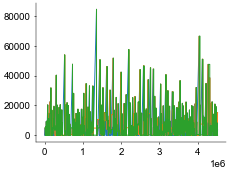

In [14]:
n = 0

plt.plot(lagged_ISIs[:, n, 0])
plt.plot(lagged_ISIs[:, n, 1])
plt.plot(lagged_ISIs[:, n, 2])

In [15]:
spktrain.shape

(34, 4519193)

In [4]:
lib.inference.loaders.SpikeTrainLoader()

<module 'lib.inference.loaders' from '/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../lib/inference/loaders.py'>

In [ ]:
from scipy.signal import hilbert


data = np.load('./checkpoint/hc5_13_eeg.npz')


# hilbert signal of filtered
eeg_filt = utils.signal.filter_signal(eeg_t, 5., 12., sample_bin)

analytic_signal = hilbert(eeg_filt[:])
#hilbert_amp = np.abs(analytic_signal)
hilbtheta_t = np.unwrap(np.angle(analytic_signal))

np.savez_compressed('./checkpoint/hc5_13_2.npz', arena=arena, eeg_t=eeg_t, 
                    spktrain=spktrain, x_t=x_t, y_t=y_t, s_t=s_t, dir_t=dir_t, hd_t=hd_t, theta_t=theta_t)

In [3]:
left_x, right_x, bottom_y, top_y = arena
units_used = spktrain.shape[0]

In [4]:
behav_data = (x_t, y_t)

bin_size = 500
tbin, resamples_, rc_t_, rcov_t = neural_utils.BinTrain(bin_size, sample_bin, spktrain, 
                                                            spktrain[0].shape[0], behav_data, average_behav=True, binned=True)

In [5]:
# Gaussian
filter_size = 1001
t = np.arange(filter_size)
t_cent = (filter_size // 2)
l_filt = 10 # 1000 ms gaussian std
smth_filter = np.exp(-0.5*((t-t_cent)/l_filt)**2)
smth_filter = smth_filter / smth_filter.sum() # normalize

rc_t_g = neural_utils.smoothen_binned_train(rc_t_/tbin, smth_filter, dev)

In [26]:
resamples = 2000
k = 0

rc_t = rc_t_[:, k*resamples:(k+1)*resamples]
rx_t = rcov_t[0][k*resamples:(k+1)*resamples]
ry_t = rcov_t[1][k*resamples:(k+1)*resamples]

In [ ]:
fig = plt.figure(figsize=(8,5))

widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights, 
                        left=0., right=0.35, bottom=0.55, top=1.0)


start = neurpass_start[n]
end = start+neurpass_len[n]
traj = [0, 1, 2]
indicator = [-0.5, 0.3, 0.3] # left or right (0,1)

ax = fig.add_subplot(spec[0, 0])
ax.text(-0.21, 1.16, 'A', transform=ax.transAxes, size=15)
grid_shape = (left_x, right_x, bottom_y, top_y)
_, ax = vs.visualize_field_(np.transpose(sp_rate[unit_used[n]]), grid_shape, 
                            figax=(fig, ax), ticktitle='firing rate (Hz)', aspect='equal')




for i, tr in enumerate(traj):
    ax.plot(x_t[start[tr]:end[tr]], y_t[start[tr]:end[tr]], \
            color='w')
    ax.text(x_t[start[tr]]+indicator[i], y_t[start[tr]]-5., str(tr+1), 
            color='tab:orange', fontdict={'weight': 'bold', 'size': 14})



widths = [1, 1]
heights = [1, 3]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights,
                        left=0.55, right=1.0, bottom=0.55, top=1.0)


# Histogram (differential of KS curve)
samples = len(q_cdf_CNT)
bins = np.linspace(0.0, 1.0, 31)

axes = fig.add_subplot(spec[0, 0])
axes.text(-0.4, 1.4, 'B', transform=axes.transAxes, size=15)
axes.xaxis.set_minor_locator(MultipleLocator(1))
axes.set_xlim(0.0, 1.0)
axes.set_xticks([])
axes.hist(q_cdf_CNT, bins=bins, edgecolor='b', facecolor=(0.95, 0.95, 0.95), density=True)
axes.plot(bins, np.ones_like(bins), 'r--')
axes.set_ylabel(r"$p(q)$", fontsize=12)
axes.set_title('Count method', fontsize=14, pad=10)

axes2 = fig.add_subplot(spec[1, 0])
tools.decorate_ax(axes2, ylabel="empirical distribution", xlim=[0.0, 1.0], ylim=[0.0, 1.0],
                  xticks=[0, 1], yticks=[0, 1])
bb = np.arange(0, samples+1)/samples
line, = axes2.plot(bb, bb, 'r--')
axes2.fill_between(
    bins, bins-s_KS_CNT*np.ones_like(bins),
    bins+s_KS_CNT*np.ones_like(bins), color='grey', alpha=0.5
)
line, = axes2.plot(q_order_CNT, bb, 'b')

axes2.text(.05, .815, r'$p_{KS}=$'+r'{:.2f}'.format(p_KS_CNT), ha='left', va='center', fontsize=11)
axes2.text(.05, .9, r'$p_{DS}=$'+r'{:.2f}'.format(p_DS_CNT), ha='left', va='center', fontsize=11)




# Histogram (differential of KS curve)
samples = len(q_cdf_ISI)

axes3 = fig.add_subplot(spec[0, 1])
axes3.xaxis.set_minor_locator(MultipleLocator(1))
axes3.set_xlim(0.0, 1.0)
axes3.set_xticks([])
axes3.hist(q_cdf_ISI, bins=bins, edgecolor='b', facecolor=(0.95, 0.95, 0.95), density=True)
axes3.plot(bins, np.ones_like(bins), 'r--')
axes3.set_title('ISI method', fontsize=14, pad=10)

axes4 = fig.add_subplot(spec[1, 1])
tools.decorate_ax(axes4, xlim=[0.0, 1.0], ylim=[0.0, 1.0],
                  xticks=[0, 1], yticks=[0, 1])
bb = np.arange(0, samples+1)/samples
line, = axes4.plot(bb, bb, 'r--')
axes4.fill_between(
    bins, bins-s_KS_ISI*np.ones_like(bins),
    bins+s_KS_ISI*np.ones_like(bins), color='grey', alpha=0.5
)
line, = axes4.plot(q_order_ISI, bb, 'b')

"""
texts = [r'$p_{DS}=$'+r'{:.1e}'.format(p_DS), r'$p_{KS}=$'+r'{:.1e}'.format(p_KS)]
colors = ['black','black']
Texts = []
for t,c in zip(texts,colors):
    Texts.append(TextArea(t, textprops=dict(color=c, fontsize=12)))
texts_vbox = VPacker(children=Texts, pad=2, sep=0)
ann = AnnotationBbox(texts_vbox, (.05,.875), xycoords=axes4.transAxes,
                            box_alignment=(0,.5), bboxprops = 
                            dict(facecolor=(0.9, 0.9, 0.9), boxstyle='round'))
ann.set_figure(fig)
fig.artists.append(ann)
"""

axes4.text(.05, .815, r'$p_{KS}=$'+r'{:.2f}'.format(p_KS_ISI), ha='left', va='center', fontsize=11)
axes4.text(.05, .9, r'$p_{DS}=$'+r'{:.2f}'.format(p_DS_ISI), ha='left', va='center', fontsize=11)


axes2.text(1.1, -0.2, r'quantile $q$', ha='center', va='center', fontsize=12)



# Z score comparison
z_tot = []
for u in [n]:#range(units_used):
    # compute the dispersion value z
    passes = neurpass_avg[u].shape[0]
    z = np.empty(passes)
    for p in range(passes):
        #sgn = (i_spikes[p] > i_avg[p])*2 - 1
        sgn = 0.0 # correction is appropriate for CDF
        z[p] = (len(neurpass_spikes[u][p])-neurpass_avg[u][p]-sgn*0.5)/np.sqrt(neurpass_avg[u][p])
    z_tot.append((z, neurpass_len[u]*sample_bin))

# histogram of z values for all used place cels
unzip = list(zip(*z_tot))
z_val = np.concatenate(unzip[0])
pass_len = np.concatenate(unzip[1])
tot_passes = pass_len.shape[0]
print(tot_passes)

mu = 0.0
sigma = 1.0



widths = [1, 1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights,
                        left=0.0, right=1.0, bottom=0.0, top=0.4)

axes = fig.add_subplot(spec[0, 0])
axes.text(-0.25, 1.1, 'C', transform=axes.transAxes, size=15)
axes.xaxis.set_minor_locator(MultipleLocator(1))
zm = 3*np.var(z_val)
bins = np.linspace(-zm, zm, 100)
y = scstats.norm.pdf(bins, mu, sigma)
axes.set_xlim(-zm, zm)
axes.set_title(r'$Z$-score')
axes.hist(z_val, bins=bins, edgecolor='grey', facecolor='grey', density=True)
axes.plot(bins, y, 'r')
axes.legend(['Theory', 'Data'])
#axes.set_xlabel("$Z$")
axes.set_ylabel("Probability")
axes.text(0.5, 0.1, r'$\sigma^2=${:.2f}'.format(np.var(z_val)), color='b', 
          fontsize=12, transform=axes.transAxes, ha='center')



z_tot_CNT = scstats.norm.isf(1. - q_cdf_CNT)
z_tot_ISI = scstats.norm.isf(1. - q_cdf_ISI)

axes = fig.add_subplot(spec[0, 1])
axes.xaxis.set_minor_locator(MultipleLocator(1))
zm = 3*np.var(z_tot_CNT)
bins = np.linspace(-zm, zm, 100)
y = scstats.norm.pdf(bins, mu, sigma)
axes.set_xlim(-zm, zm)
axes.set_title('Count')
axes.hist(z_tot_CNT, bins=bins, edgecolor='grey', facecolor='grey', density=True)
axes.plot(bins, y, 'r')
#axes.legend(['Theory ($\sigma^2=1$)', 'Data ($\sigma^2={:.2f}$)'.format(z_var)])
axes.set_xlabel("$Z$")
#axes.set_ylabel("Probability")
axes.text(0.5, 0.1, r'$\sigma^2=${:.2f}'.format(np.var(z_tot_CNT)), color='b', 
          fontsize=12, transform=axes.transAxes, ha='center')



axes = fig.add_subplot(spec[0, 2])
axes.xaxis.set_minor_locator(MultipleLocator(1))
zm = 3*np.var(z_tot_ISI)
bins = np.linspace(-zm, zm, 100)
y = scstats.norm.pdf(bins, mu, sigma)
axes.set_xlim(-zm, zm)
axes.set_title('ISI')
axes.hist(z_tot_ISI, bins=bins, edgecolor='grey', facecolor='grey', density=True)
axes.plot(bins, y, 'r')
#axes.legend(['Theory ($\sigma^2=1$)', 'Data ($\sigma^2={:.2f}$)'.format(z_var)])
#axes.set_xlabel("$Z$")
#axes.set_ylabel("Probability")
axes.text(0.5, 0.1, r'$\sigma^2=${:.2f}'.format(np.var(z_tot_ISI)), color='b', 
          fontsize=12, transform=axes.transAxes, ha='center')



# Fisher F test, but denominator is unit normal
F = np.var(z_val, ddof=1) # sample variance
df = len(z_val) - 1
F_z = scstats.chi2.sf(F, df)
print(F_z) # extremely small
print(F)



plt.savefig('output/Z_score.svg')
plt.savefig('output/Z_score.pdf')
plt.show()